In [1]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import spacy
#needed for lemmatization, disabling parser and ner just makes it a little faster since we aren't using those capabilities
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns

from gensim import corpora

#for creating ngrams
from gensim.models import phrases, Phrases
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# this code keeps the pyldavis from changing the display in a weird way
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

# this is the only way I could see how to import custom a custom module from an adjacent directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Functions.tokenization import tokenize
from Functions.tfidf_display_helper import display_side_by_side


warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/eric_s/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# lineterminator='\n' prevents a parsing error
posts = pd.read_csv('Data/preprocessed_posts.csv', lineterminator='\n')
posts

,subreddit,all_text,id,created_utc,title,selftext
0,Keratoconus,anyone here i was surprised to see no pun inte...,ppja5,1329249287,Anyone here?,I was surprised to see (no pun intended) that ...
1,Keratoconus,strabismus and keratoconus i was just diagnose...,1gbg5v,1371182579,Strabismus and Keratoconus?,I was just diagnosed with KC a few days ago. I...
2,Keratoconus,19 months post corneal transplant and i can se...,1g2mdm,1370899466,19 months post corneal transplant and I can see!,"Hi guys,\n\nI posted this yesterday in /r/self..."
3,Keratoconus,informations on how to treat keratoconus and s...,1faa1w,1369853969,Informations on how to treat Keratoconus and s...,"Hi, my cousin was diagnosed with Keratoconus, ..."
4,Keratoconus,any help for a newly diagnosed got diagnosed a...,1ddiew,1367279940,Any help for a newly diagnosed?,Got diagnosed a few days ago. My left eye is a...
...,...,...,...,...,...,...
93933,MonoHearing,recent ssd sshl this past thursday i was on a ...,bec55x,1555530344,Recent SSD/SSHL,This past Thursday I was on a flight and passe...
93934,MonoHearing,sshl question i was diagnosed with sshl on my ...,bea3ij,1555519826,SSHL question,I was diagnosed with SSHL on my left side back...
93935,MonoHearing,mono switchable headphones with individual vol...,bbmv0u,1554907552,Mono Switchable Headphones with individual vol...,Consideration for the useful gadgets list - I...
93936,MonoHearing,how to see sound in fortnite quickly _ visuali...,bavdxz,1554738446,How to See Sound in Fortnite Quickly - Visuali...,How to See Sound in Fortnite Quickly - Visuali...


In [3]:
cf = posts[posts['subreddit']=='CysticFibrosis'].reset_index(drop=True).copy()
cf

,subreddit,all_text,id,created_utc,title,selftext
0,CysticFibrosis,alright do you have cf or do you know someone ...,slsoc,1335045269,"Alright, do you have CF or do you know someone...",I just found this subreddit.. and am curious a...
1,CysticFibrosis,anyone on cayston issues with altera neb i hav...,sdjxd,1334630439,Anyone on Cayston? Issues with Altera neb?,I've been on it every other month for quite so...
2,CysticFibrosis,anyone else with a peg feeding tube implant th...,sccnb,1334583362,Anyone else with a PEG feeding tube implant th...,"I don't get hungry, my stomach doesn't rumble...."
3,CysticFibrosis,before and after of my brothers lungs after th...,s21f7,1334030971,Before and after of my brother's lungs after t...,This is a before and after shot of my brothers...
4,CysticFibrosis,support from houston tx crawin for the cure is...,s0ybt,1333988203,Support from Houston TX,Crawin' for the Cure is a Houston based group ...
...,...,...,...,...,...,...
7118,CysticFibrosis,what are the side effects of trikafta do they ...,ed511t,1576816062,What are the side effects of trikafta,Do they include heavy coughing and difficulty ...
7119,CysticFibrosis,diflucan fluconazole resistant yeast infection...,ed4o0u,1576814100,Diflucan (fluconazole) resistant yeast infection?,"Hi all, \n\nProbably like many of us using ant..."
7120,CysticFibrosis,life perspective i want to start this post by ...,ecyz8w,1576787693,Life Perspective,I want to start this post by saying that CF is...
7121,CysticFibrosis,i have not hit my inhaler in almost a month th...,ecv1h0,1576770831,I haven't hit my inhaler in almost a month,"Thank you, trikafta. I haven't even felt compe..."


In [4]:
train_df, val_df = train_test_split(cf, test_size=.05, random_state=0)
len(train_df), len(val_df)

(6766, 357)

In [5]:
train_tokens = tokenize(train_df)
val_tokens = tokenize(val_df)

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(train_tokens)

# instead of keeping a big and ever-changing list of stop words, filter_extremes is a decent way to do this in one line 
id2word.filter_extremes(no_above=.5, no_below=2)

# Represent Corpus as BOW vector for each post
corpus = [id2word.doc2bow(text) for text in train_tokens]

In [7]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=5,
                   passes=20,
                   random_state=1)

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=False)
LDAvis_prepared

#* I prefer to view relevant terms by topic with a lambda of .2  A lower lambda value ranks relevant terms ,that are -
# - highly specific to that topic, higher than terms with only a high overall frequency.
# This basically results in terms that are more specialized to the topic and thus more descriptive

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.001229  0.035077       1        1  39.987394
1     -0.169421 -0.084954       2        1  19.491722
2      0.147162 -0.157741       3        1  11.229245
3      0.143079  0.128271       4        1  16.699709
4     -0.119591  0.079348       5        1  12.591928, topic_info=         Term         Freq        Total Category  logprob  loglift
14         cf  5809.000000  5809.000000  Default  30.0000  30.0000
26       feel  3392.000000  3392.000000  Default  29.0000  29.0000
16      cough  1174.000000  1174.000000  Default  28.0000  28.0000
70       test   760.000000   760.000000  Default  27.0000  27.0000
514  trikafta  1528.000000  1528.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
226      know   231.750685  3590.329667   Topic5  -5.0634  -0.6682
45       make   195.514683  2097.193075   Topic5  -5.2334  -0.3006
27       find   183.656116  1304.058237   Topic5  -5.2960   0.1119
67      start   183.536714  2264.592706   Topic5  -5.2966  -0.4406
107       see   173.393542  1598.695312   Topic5  -5.3535  -0.1493

[404 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4105      5  0.986497    amikacin
548       1  0.007960  antibiotic
548       2  0.705767  antibiotic
548       3  0.007960  antibiotic
548       5  0.278592  antibiotic
...     ...       ...         ...
86        1  0.500258        year
86        2  0.092557        year
86        3  0.150639        year
86        4  0.158509        year
86        5  0.097803        year

[737 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [9]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.2 # Adjust this accordingly based on tuning above
for i in range(1,6): #Adjust this to reflect number of topics chosen for final LDA model
    topic = LDAvis_prepared.topic_info[LDAvis_prepared.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

topics_df = pd.DataFrame(all_topics).T
topics_df

,0,1,2,3,4,5,6,7,8,9
Topic 1,life,school,die,friend,want,eat,weight,enzyme,people,love
Topic 2,cough,pain,trikafta,mucus,dose,throat,chest,fever,sleep,side__effects
Topic 3,test,mutation,carrier,gene,sweat__test,diagnosis,diagnose,testing,gi,result
Topic 4,insurance,pay,pharmacy,program,canada,cost,company,transplant,country,fly
Topic 5,mask,port,nebulizer,cayston,tobi,culture,machine,smoke,app,tube


In [10]:
topic_dict = dict((("Topic_1", "Daily Life"), ("Topic_2", "Medication & Side Effects"), ("Topic_3", "Testing & Diagnosis"), 
 ("Topic_4", "Insurance"), ("Topic_5", "Medical Equipment")))

In [11]:
topic_vecs = []
for i in range(len(train_tokens)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(5)]
    topic_vecs.append(topic_vec)

topic_score_vectors = pd.DataFrame(topic_vecs, columns=topic_dict.keys())

posts_w_scores = pd.concat([train_df.reset_index(),topic_score_vectors], axis=1)

posts_w_scores['dominant_topic'] = posts_w_scores[topic_dict.keys()].idxmax(axis=1)

posts_w_scores['dom_label'] = posts_w_scores['dominant_topic'].map(topic_dict)

posts_w_scores['dom_percent'] = np.round(posts_w_scores[topic_dict.keys()].max(axis=1),3)

posts_w_scores

,index,subreddit,all_text,id,created_utc,title,selftext,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,dominant_topic,dom_label,dom_percent
0,4649,CysticFibrosis,is it worth asking to be tested female over 30...,nf65qv,1621330086,Is it worth asking to be tested?,"Female, over 30. \n\nHave been smoking weed fo...",0.200811,0.343093,0.357097,0.001897,0.097103,Topic_3,Testing & Diagnosis,0.357
1,4934,CysticFibrosis,milder cfer starting kaftrio what to expect i ...,mgc86w,1617097379,"milder CFer starting kaftrio, what to expect.",I've always been described by my doctor as som...,0.009853,0.380456,0.425035,0.174846,0.009811,Topic_3,Testing & Diagnosis,0.425
2,2632,CysticFibrosis,other than swwat test for infants is there oth...,92dkf5,1532705876,"Other than swwat test for infants, is there ot...",My child came out positive on one mutation for...,0.007675,0.218595,0.630705,0.007576,0.135448,Topic_3,Testing & Diagnosis,0.631
3,2588,CysticFibrosis,appetite gone so i am in a super hot city righ...,c3os8x,1561204099,Appetite gone,So I’m in a super hot city right now and it’s ...,0.412046,0.361180,0.005963,0.214753,0.006058,Topic_1,Daily Life,0.412
4,2868,CysticFibrosis,live fast die young an abnormal cf life hi the...,k0nsjp,1606290321,"Live fast, Die young (An Abnormal CF life)",Hi there.\nThe reason for me writing this stor...,0.952068,0.000494,0.000488,0.015657,0.031293,Topic_1,Daily Life,0.952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6761,4931,CysticFibrosis,taking a drug test hi i have to take a drug te...,mgiuw4,1617118907,Taking a drug test,Hi! I have to take a drug test for my new job ...,0.012887,0.012922,0.754339,0.207140,0.012712,Topic_3,Testing & Diagnosis,0.754
6762,3264,CysticFibrosis,what is it worth to you here i am older than i...,5jbar9,1482208481,What's it worth to you?,Here I am. Older than I thought i'd be. In a b...,0.846105,0.001836,0.001818,0.148426,0.001815,Topic_1,Daily Life,0.846
6763,1653,CysticFibrosis,do any of you have symptoms like me hey guys\n...,o1ny06,1623902470,Do any of you have symptoms like me?,"Hey guys,\nTrying to figure out what’s going o...",0.273281,0.402693,0.317993,0.003014,0.003019,Topic_2,Medication & Side Effects,0.403
6764,2607,CysticFibrosis,first time 2yo son is being hospitalized wish ...,c277bn,1560888763,"First time 2yo son is being hospitalized, wish...",My 2 year old son with CF has had a persistent...,0.500834,0.089755,0.173956,0.005501,0.229954,Topic_1,Daily Life,0.501


# Validation & Threshold Testing

In [12]:
ground_truth = pd.read_csv("Data/cf_validation_ground_truth_labels.csv")
ground_truth.head()

,index,title,selftext,label
0,1189,Port and Vest question,I got my port placed about two months ago. I h...,5.0
1,5879,Help with how to verbalize this issue to our C...,My 3 year old has CF. He has started throwing ...,2.0
2,5373,CF and jobby jobs,"Recently I had a drop in PFTs and a tune-up, a...",2.0
3,3391,Something we can all get behind.,This is a link to a petition site to Chief Exe...,1.0
4,5723,Nebulizer and Vest,Hi everyone. Sorry for formatting. On mobile. ...,5.0


In [13]:
val_corpus = [id2word.doc2bow(text) for text in val_tokens]

In [14]:
topic_vecs = []
for i in range(len(val_tokens)):
    top_topics = lda_model.get_document_topics(val_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(5)]
    topic_vecs.append(topic_vec)

topic_score_vectors = pd.DataFrame(topic_vecs, columns=topic_dict.keys())

val_scores = pd.concat([val_df.reset_index(),topic_score_vectors], axis=1)

val_scores['dominant_topic'] = val_scores[topic_dict.keys()].idxmax(axis=1)

val_scores['dom_label'] = val_scores['dominant_topic'].map(topic_dict)

val_scores['dom_percent'] = np.round(val_scores[topic_dict.keys()].max(axis=1),3)

In [15]:
ground_truth['label'] = ground_truth['label'].astype(str)
translate = dict((("1.0","Topic_1"), ("2.0", "Topic_2"), ("3.0", "Topic_3"), ("4.0", "Topic_4"), ("5.0", "Topic_5")))
ground_truth['label'] = ground_truth['label'].map(translate)

In [16]:
val_scores = val_scores.iloc[:100]
ground_truth = ground_truth.iloc[:100]
val_scores['ground_truth'] = ground_truth['label']
val_scores['prediction_is_correct'] = (val_scores['dominant_topic']==val_scores['ground_truth'])

In [17]:
threshold_results = []

threshold_range = [None, .4, .5, .6, .7, .8, .9]

for cut_off in threshold_range:
    
    if cut_off is not None:
    
        trues = (val_scores[val_scores['dom_percent']>=cut_off]['prediction_is_correct']==True).sum()
        falses = (val_scores[val_scores['dom_percent']>=cut_off]['prediction_is_correct']==False).sum()
    else:
        trues = (val_scores['prediction_is_correct']==True).sum()
        falses = (val_scores['prediction_is_correct']==False).sum()  
        cut_off = .3
        
    threshold_results.append((cut_off, np.round(trues/(trues+falses), 3), trues+falses))

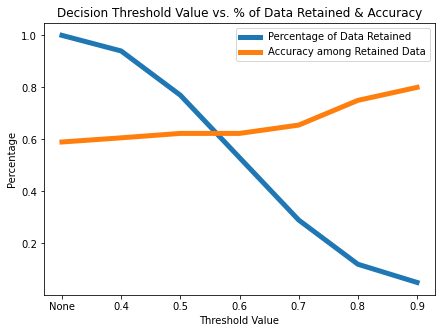

In [27]:
x = [acc for thresh,acc,data in threshold_results]
y = [data for thresh,acc,data in threshold_results]
z = [thresh for thresh,acc,data in threshold_results]

plt.figure(figsize=(7,5))
sns.lineplot(x=z, y=np.array(y)/100, linewidth=5)
sns.lineplot(x=z, y=np.array(x), linewidth=5)
plt.title('Decision Threshold Value vs. % of Data Retained & Accuracy', fontsize=12)
plt.xlabel('Threshold Value', fontsize=10)
plt.ylabel('Percentage', fontsize=10)
plt.legend(['Percentage of Data Retained', 'Accuracy among Retained Data'])
# plt.yticks(fontsize=20)
plt.xticks(z,['None']+z[1:])
plt.show()

In [19]:
df = pd.DataFrame(threshold_results, columns=['Decision Threshold', 'Accuracy', '% of Data Retained'])
df.iloc[0, 0] = "None"
df

,Decision Threshold,Accuracy,% of Data Retained
0,None,0.590,100
1,0.4,0.606,94
2,0.5,0.623,77
3,0.6,0.623,53
4,0.7,0.655,29
5,0.8,0.750,12
6,0.9,0.800,5


# Results

In [20]:
threshold_satisfying = posts_w_scores[posts_w_scores['dom_percent']>=.5]
len(threshold_satisfying), len(posts_w_scores)

(5334, 6766)

In [21]:
5334/6766

0.788353532367721

# TF-IDF

### Only Unigrams

In [51]:
dominant_topic_corpus = []
for topic in topic_dict.keys():
    bigstring = ' '.join(list(threshold_satisfying[threshold_satisfying['dominant_topic']==topic]['all_text'].values))    
    dominant_topic_corpus.append(bigstring)
    
unigram_vectorizer = TfidfVectorizer(stop_words='english', max_df=3)
tfidf_unigrams = unigram_vectorizer.fit_transform(dominant_topic_corpus)

In [52]:
side_by_side = []
for i,topic in enumerate(topic_dict.values()):
    current_topic = tfidf_unigrams[i]
    df = pd.DataFrame(current_topic.T.todense(), index=unigram_vectorizer.get_feature_names(), columns=[topic])
    df = df[df[topic]>0]
    df = df.sort_values(by=[topic],ascending=False).head(15)
    side_by_side.append(df)

In [53]:
display_side_by_side(side_by_side, topic_dict.values())

,Daily Life
depression,0.203764
fun,0.149349
dying,0.124158
kjv,0.110159
gym,0.093568
sex,0.093568
belly,0.091044
lbs,0.088876
feelings,0.088170
games,0.088170


In [54]:
tfidf = pd.DataFrame()
for i,topic in enumerate(topic_dict.values()):
      tfidf[topic] = side_by_side[i].index
        
tfidf.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Daily Life,depression,fun,dying,kjv,gym,sex,belly,lbs,feelings,games,bathroom,relationships,angry,fighting,wear
Medication & Side Effects,throat,purge,sinuses,smell,woke,tightness,hair,symkevi,shortness,hemoptysis,headaches,pft,spit,cardio,bactrim
Testing & Diagnosis,carriers,crms,vas,infertility,fertility,deferens,stool,pancreatitis,borderline,sperm,counselor,inconclusive,pediatrician,variant,panel
Insurance,foundation,medicaid,program,coverage,medicare,disability,awareness,donate,survey,copay,donation,fundraising,government,united,fund
Medical Equipment,port,pari,monarch,picc,eflow,masks,compressor,lc,cup,vios,plastic,afflovest,sterilizer,sterilize,wear


### Only Bigrams

In [55]:
bigram_vectorizer = TfidfVectorizer(stop_words='english', max_df=3, ngram_range=(2,2))
tfidf_bigrams = bigram_vectorizer.fit_transform(dominant_topic_corpus)

side_by_side = []
for i,topic in enumerate(topic_dict.keys()):
    current_topic = tfidf_bigrams[i]
    df = pd.DataFrame(current_topic.T.todense(), index=bigram_vectorizer.get_feature_names(), columns=[topic])
    df = df[df[topic]>0]
    df = df.sort_values(by=[topic],ascending=False).head(15)
    side_by_side.append(df)
    
display_side_by_side(side_by_side, topic_dict.values())

,Topic_1
best friend,0.060393
life expectancy,0.052844
going die,0.051334
makes feel,0.048314
feeling like,0.046805
cf really,0.045295
depression anxiety,0.045089
family friends,0.043785
live life,0.043785
time job,0.041834


In [56]:
tfidf = pd.DataFrame()
for i,topic in enumerate(topic_dict.values()):
      tfidf[topic] = side_by_side[i].index
        
tfidf.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Daily Life,best friend,life expectancy,going die,makes feel,feeling like,cf really,depression anxiety,family friends,live life,time job,friend cf,friends family,double lung,die young,feel guilty
Medication & Side Effects,chest pain,sinus surgery,stomach pain,shortness breath,chest tightness,short breath,started taking,blood pressure,cough mucus,feeling like,hair loss,heart rate,coughing lot,coughing fit,lung infections
Testing & Diagnosis,genetic testing,atypical cf,vas deferens,test results,sweat tests,cf carrier,blood test,sweat chloride,genetic counselor,just carrier,genetic test,just diagnosed,symptoms cf,sinus infections,cf symptoms
Insurance,travel insurance,people cystic,health care,raise money,fibrosis foundation,united states,copay assistance,double lung,feet apart,cf care,cf foundation,fibrosis canada,chronic illness,life insurance,help cf
Medical Equipment,pari lc,weekly checkup,picc line,baby bottle,nebulizer cups,monarch vest,pari vios,neb cups,grape juice,bottle sterilizer,28 days,vios pro,use pari,air purifier,nebulizer machine


# Distribution

/home/eric_s/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


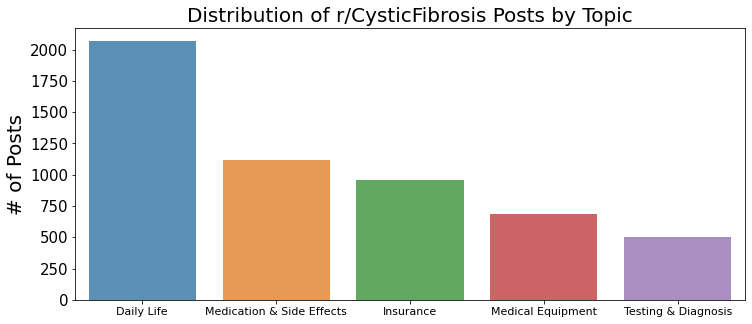

In [57]:
search_term_count  = threshold_satisfying['dom_label'].value_counts()
plt.figure(figsize=(12,5))
sns.barplot(search_term_count.index, search_term_count.values, alpha=0.8)
plt.title('Distribution of r/CysticFibrosis Posts by Topic', fontsize=20)
plt.ylabel('# of Posts', fontsize=20)
# plt.xlabel("Topic", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=11)
plt.show()